In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import nltk
from nltk.corpus import stopwords
from collections import Counter
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
import spacy
import datetime
import ssl
from matplotlib.ticker import PercentFormatter
import plotly.graph_objects as go

In [2]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/lenguyen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
nlp = spacy.load("en_core_web_sm")
def cleanData(messages):
    for i in range(0,len(messages)):
        try:
            doc = nlp(messages.iloc[i])
            token_list = [token for token in doc]
            filtered_tokens = [token for token in doc if not token.is_stop]
            lemmas = [token.lemma_ for token in filtered_tokens]
            s = ' '.join(lemmas)
            
            messages.iloc[i] = s
        except:
            messages.iloc[i] = ""
        
        #if is_ascii(messages.iloc[i]) == False:
             #messages.iloc[i] = ""

    return messages

In [4]:
def getSentiment(message):
    return  sia.polarity_scores(message)['compound']

def convertDate(date):
    dates = date.split("-")
    convert = datetime.date(int(dates[0]), int(dates[1]), int(dates[2]))
    return convert

In [5]:
def connectivity(edgeSentiments):
    posPos = 0
    negNeg = 0
    posNeg = 0

    for pair in edgeSentiments:
        if np.sign(pair[0]) == np.sign(pair[1]) and np.sign(pair[0]) == 1:
            posPos += 1
        elif np.sign(pair[0]) == np.sign(pair[1]) and np.sign(pair[0]) == -1:
            negNeg += 1
        elif np.sign(pair[0]) != np.sign(pair[1]) and pair[0] != 0 and pair[1] != 0:
            posNeg += 1
    return posPos,negNeg, posNeg

def rawConnectivity(edgeSentiments):
    connections = []
    for pair in edgeSentiments:
        if np.sign(pair[0]) != 0 and np.sign(pair[1]) != 0:
            connections.append([np.sign(pair[0]),np.sign(pair[1])])
    return connections
    
    
    

# Get Metrics From All Threads

In [6]:
#Load Data
data = pd.read_csv("CleanData/GawaherClean.csv", index_col=0)
threads = data["ThreadID"].unique()
#Load Sentiment analyzer
sia = SentimentIntensityAnalyzer()

meanSentiment = []
posterSentiment = []
posterCentrality = []
numPosterPosts = []
numMembers = []
numPosts = []
allConnection = []
uniqueConnection = []
rawConnections = []
rawUniqueConnections = []

for num in range(0,len(threads)):
    thread = data[data["ThreadID"]== threads[num]]
    thread = thread.reset_index(drop = True)

    #get all messages
    messages = thread["Message"].copy()
    
    #Add sentiment values
    thread["sentiment"] = np.zeros(len(thread))

    for i in range(0,len(thread)):
        try:
            thread["sentiment"].iloc[i] = getSentiment(thread.iloc[i]["Message"])
        except:
            pass
    
    #sort by datetime
    for i in range(0,len(thread)):
        thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
    thread = thread.sort_values(by = ["P_Date",'﻿MessageID'])
    
    #Encode non-numerical members
    index = -1
    members = thread["MemberID"].unique()
    for i in range(0,len(members)):
        try:
            int(members[i])
        except:
            thread["MemberID"][thread["MemberID"] == members[i]] = str(index)
            members[i] = str(index)
            index -= 1
    
    memberSentiments = []
    memberCommnets = []
    for i in members:
        memberCommnets.append(len(thread[thread["MemberID"] == i]))
        memberSentiments.append(np.mean(thread[thread["MemberID"] == i]["sentiment"]))
                                
              
    #Make graph
    #Make dictionary of nodes (members) with corresponding mean sentiment of that member
    nodes = np.array(members,dtype = int)
    nodeDict = dict(zip(nodes,np.around(memberSentiments,4)))
    
    edges = []
    for i in range(0,len(thread)-1):
        if thread["MemberID"].iloc[i] != thread["MemberID"].iloc[i +1]:
            edge = (tuple([int(thread["MemberID"].iloc[i]),int(thread["MemberID"].iloc[i+1])]))
            edges.append(edge)
    
    sortEdges = [np.sort(x) for x in edges]
    edgeKeys = np.unique(sortEdges,axis=0)
    edgeValues = []

    for i in range(0,len(edgeKeys)):
        count = 0
        for j in range(0,len(sortEdges)):
            count += np.array_equal(sortEdges[j],edgeKeys[i])
        edgeValues.append(count)

    edgeKeys=[tuple(edgeKeys.tolist()[x]) for x in range(0,len(edgeKeys))]
    edgeDict = dict(zip(edgeKeys,edgeValues))
    
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    #Get central tendency
    infoCentrality = nx.information_centrality(G)
    
    try:
        #Get all interacts between members also unique interactions between members (remove multiple replies)
        flatEdges = np.concatenate(edges)
        flatSentiments = np.array([nodeDict[x] for x in flatEdges])
        edgeSentiments = np.sort(flatSentiments.reshape(-1,2))
        uniqueSentiments = np.unique(np.sort(edgeSentiments),axis = 0)

        #Store metrics
        allConnection.append(list(connectivity(edgeSentiments))) 
        uniqueConnection.append(list(connectivity(uniqueSentiments)))
        
        rawConnections.append(rawConnectivity(edgeSentiments))
        rawUniqueConnections.append(rawConnectivity(uniqueSentiments))
        
        
        meanSentiment.append(np.mean(thread["sentiment"]))
        numPosts.append(len(messages))
        posterSentiment.append(memberSentiments[0])  
        posterCentrality.append(infoCentrality)
        numPosterPosts.append(len(thread[thread["MemberID"] == members[0]]))
        numMembers.append(len(members))
    except:
        pass

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/var/folders/fr/03zv9zcj7j146mrr4jsb58kw0000gn/T/ipykernel_20402/2892673120.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
/var/folders/fr/03zv9zcj7j146mrr4jsb58kw0000gn/T/ipykernel_20402/2892673120.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

# Statistics

In [7]:
statistics = pd.DataFrame(np.array([posterSentiment, posterCentrality,numPosterPosts, meanSentiment, numPosts, numMembers]).T,
                          columns = ["posterSentiment", "posterCentrality", "numPosterPosts", "meanSentiment", "numPosts", "numMembers"])



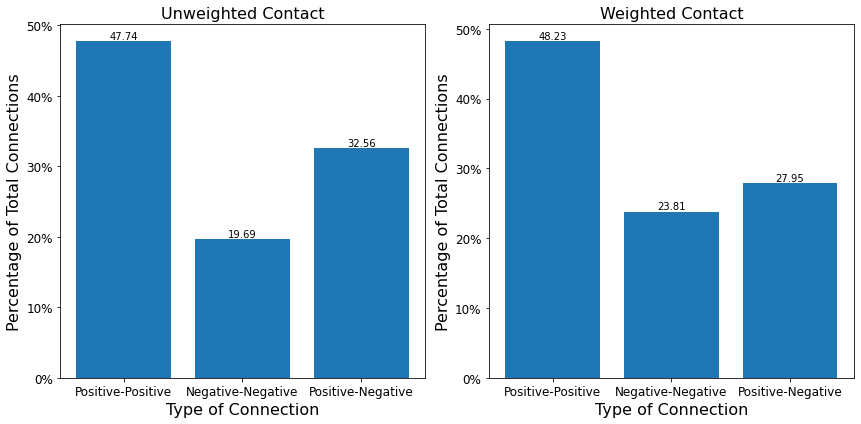

In [8]:
font = 16
tick = 12

plt.figure(figsize = (12,6))

plt.subplot(1,2,2)
plot1 = plt.bar(["Positive-Positive","Negative-Negative","Positive-Negative"],
        (np.sum(allConnection, axis = 0)/np.sum(np.sum(allConnection, axis = 0))))
plt.title("Weighted Contact", fontsize = font)
plt.ylabel("Percentage of Total Connections", fontsize = font)
plt.xlabel("Type of Connection", fontsize = font)
plt.bar_label(plot1,np.around(np.sum(allConnection, axis = 0)*100/np.sum(np.sum(allConnection, axis = 0)),2))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xticks(fontsize=tick)
plt.yticks(fontsize=tick)

plt.subplot(1,2,1)
plot2 = plt.bar(["Positive-Positive","Negative-Negative","Positive-Negative"],
       (np.sum(uniqueConnection, axis = 0 )/np.sum(np.sum(uniqueConnection, axis = 0 ))))
plt.title("Unweighted Contact", fontsize = font)
plt.ylabel("Percentage of Total Connections", fontsize = font)
plt.xlabel("Type of Connection", fontsize = font)
plt.bar_label(plot2,np.around(np.sum(uniqueConnection, axis = 0)*100/np.sum(np.sum(uniqueConnection, axis = 0)),2))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.tight_layout()
plt.xticks(fontsize=tick)
plt.yticks(fontsize=tick);

plt.savefig("intraThread.png")

In [16]:
47.74+19.69

67.43

In [17]:
48.23 + 23.81

72.03999999999999

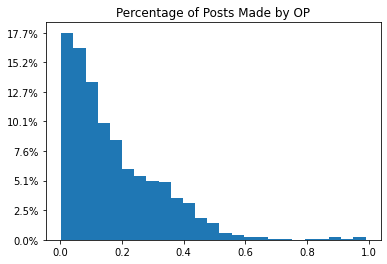

In [9]:
plt.hist(statistics["numPosterPosts"]/statistics["numPosts"], bins = 25)
plt.title("Percentage of Posts Made by OP");
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax = len(statistics)))

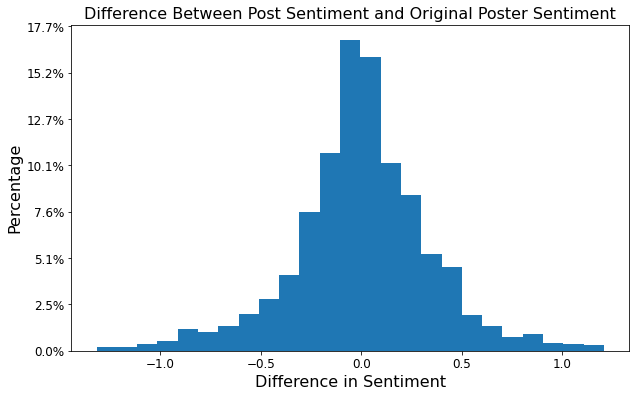

In [10]:
diff = statistics["posterSentiment"]-statistics["meanSentiment"]

plt.figure(figsize = (10,6))
plt.hist(diff, bins = 25)
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax = len(diff)))
plt.title("Difference Between Post Sentiment and Original Poster Sentiment", fontsize = font)
plt.xlabel("Difference in Sentiment", fontsize = font)
plt.ylabel("Percentage", fontsize = font);
plt.xticks(fontsize=tick)
plt.yticks(fontsize=tick);
plt.savefig("diffSentiment.png")

In [11]:
np.mean(diff)

0.0009825814944482958

In [12]:
np.std(diff)

0.34440859265628165

look at more centrality measures - information centrality, closeness centrality, game theory centrality  

# Centrality 

In [14]:
centers = []

for i in range(0,len(posterCentrality)):
    centers.append(max(posterCentrality[i], key=posterCentrality[i].get)) 
centers = -1*np.array(centers)

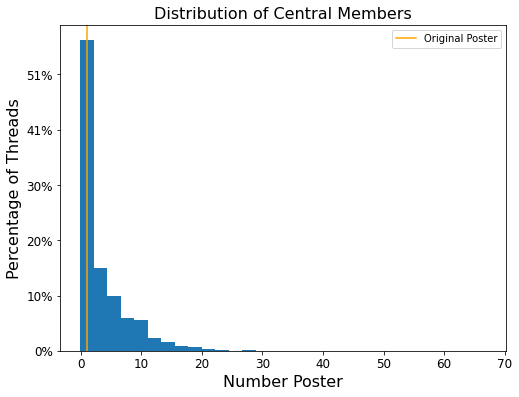

In [15]:
plt.figure(figsize = (8,6))
y = plt.hist(np.array(centers),bins = 30,  align='left')
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax = len(centers)))
plt.xlabel("Number Poster", fontsize = font)
plt.ylabel("Percentage of Threads", fontsize = font)
plt.title("Distribution of Central Members", fontsize = font)
plt.axvline(x=1, c = "orange", label = "Original Poster")
plt.xticks(fontsize=tick)
plt.yticks(fontsize=tick);
plt.legend()
plt.savefig("intraCentrality.png");